## **Economic Data Analysis using Python and Pandas**

The Notebook is a demonstrating the use of Python and Pandas for analyzing economic data. It begins by guiding the user on setting up the Federal Reserve Economic Data (FRED) API and then delves into searching for specific economic data. Subsequent sections focus on extracting and visualizing raw data, including techniques for pulling and joining multiple data series for comparative analysis. A specific case study is presented with the April 2020 unemployment rate data for various states, alongside labor force participation rates. The tutorial culminates in a comparative visualization of unemployment versus participation rates across states, providing a practical application of data analysis techniques in economic research.

In [ ]:
!pip install fredapi > /dev/null

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import time
import getpass

plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', 500)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]

from fredapi import Fred

# Securely input your FRED API key
fred_key = getpass.getpass('Enter your FRED API Key: ')

fred = Fred(api_key=fred_key)

Enter your FRED API Key: ··········


In [ ]:
sp_search = fred.search('S&P', order_by='popularity')


In [ ]:
sp_search.head()

,id,realtime_start,realtime_end,title,observation_start,observation_end,frequency,frequency_short,units,units_short,seasonal_adjustment,seasonal_adjustment_short,last_updated,popularity,notes
series id,,,,,,,,,,,,,,,
BAMLH0A0HYM2,BAMLH0A0HYM2,2024-01-02,2024-01-02,ICE BofA US High Yield Index Option-Adjusted S...,1996-12-31,2023-12-31,"Daily, Close",D,Percent,%,Not Seasonally Adjusted,NSA,2024-01-02 11:33:02-06:00,92,The ICE BofA Option-Adjusted Spreads (OASs) ar...
CSUSHPINSA,CSUSHPINSA,2024-01-02,2024-01-02,S&P/Case-Shiller U.S. National Home Price Index,1987-01-01,2023-10-01,Monthly,M,Index Jan 2000=100,Index Jan 2000=100,Not Seasonally Adjusted,NSA,2023-12-26 08:12:02-06:00,88,"For more information regarding the index, plea..."
SP500,SP500,2024-01-02,2024-01-02,S&P 500,2014-01-03,2024-01-02,"Daily, Close",D,Index,Index,Not Seasonally Adjusted,NSA,2024-01-02 19:10:58-06:00,83,The observations for the S&P 500 represent the...
MEHOINUSA672N,MEHOINUSA672N,2024-01-02,2024-01-02,Real Median Household Income in the United States,1984-01-01,2022-01-01,Annual,A,2022 CPI-U-RS Adjusted Dollars,2022 CPI-U-RS Adjusted $,Not Seasonally Adjusted,NSA,2023-09-12 13:48:02-05:00,82,Household data are collected as of March. As ...
BAMLH0A0HYM2EY,BAMLH0A0HYM2EY,2024-01-02,2024-01-02,ICE BofA US High Yield Index Effective Yield,1996-12-31,2023-12-31,"Daily, Close",D,Percent,%,Not Seasonally Adjusted,NSA,2024-01-02 11:33:05-06:00,81,This data represents the effective yield of th...


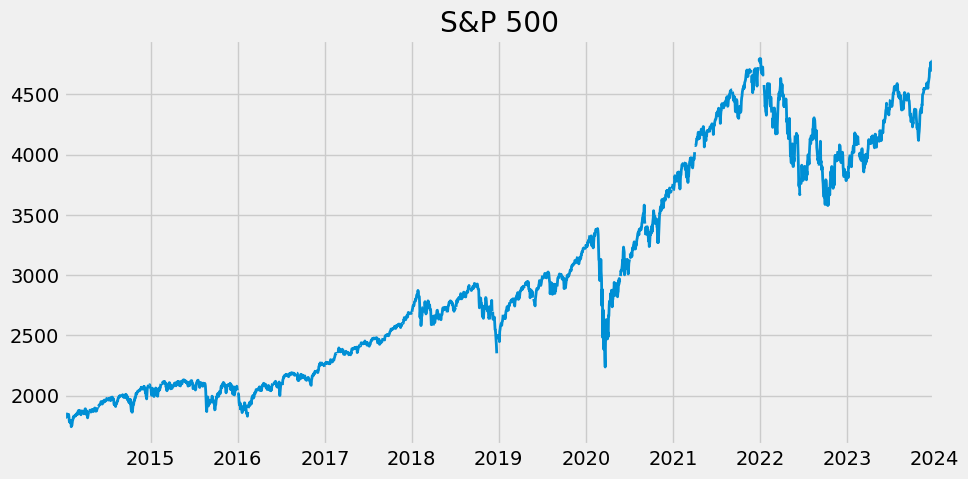

In [ ]:
sp500 = fred.get_series(series_id='SP500')
sp500.plot(figsize=(10, 5), title='S&P 500', lw=2)
plt.show()

In [ ]:
unemp_df = fred.search('unemployment rate state', filter=('frequency','Monthly'))
unemp_df = unemp_df.query('seasonal_adjustment == "Seasonally Adjusted" and units == "Percent"')
unemp_df = unemp_df.loc[unemp_df['title'].str.contains('Unemployment Rate')]

In [ ]:
all_results = []

for myid in unemp_df.index:
    results = fred.get_series(myid)
    results = results.to_frame(name=myid)
    all_results.append(results)
    time.sleep(0.1) # Don't request to fast and get blocked
uemp_results = pd.concat(all_results, axis=1)

In [ ]:
cols_to_drop = []
for i in uemp_results:
    if len(i) > 4:
        cols_to_drop.append(i)
uemp_results = uemp_results.drop(columns = cols_to_drop, axis=1)

In [ ]:
uemp_states = uemp_results.copy()  #.drop('UNRATE', axis=1)
uemp_states = uemp_states.dropna()
id_to_state = unemp_df['title'].str.replace('Unemployment Rate in ','').to_dict()
uemp_states.columns = [id_to_state[c] for c in uemp_states.columns]

In [ ]:
# Plot States Unemployment Rate
px.line(uemp_states)

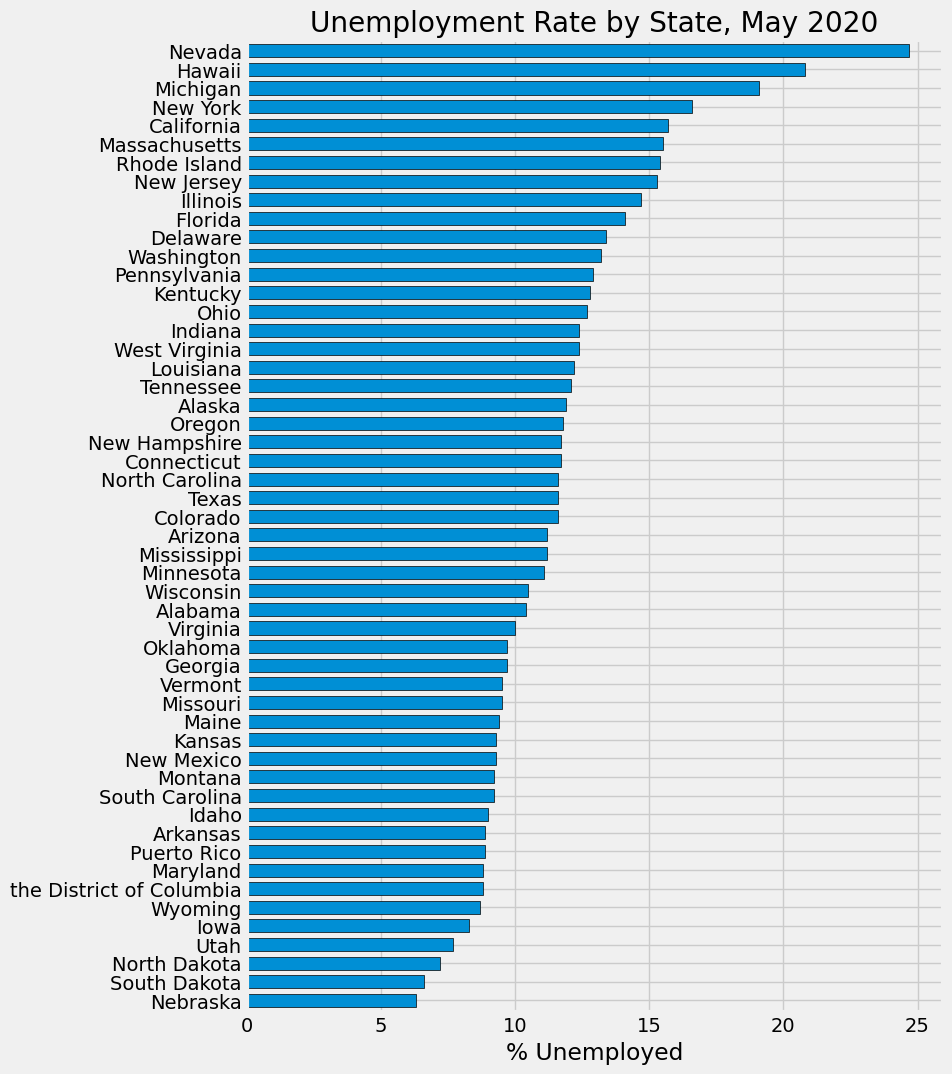

In [ ]:
ax = uemp_states.loc[uemp_states.index == '2020-05-01'].T \
    .sort_values('2020-05-01') \
    .plot(kind='barh', figsize=(8, 12), width=0.7, edgecolor='black',
          title='Unemployment Rate by State, May 2020')
ax.legend().remove()
ax.set_xlabel('% Unemployed')
plt.show()

In [ ]:
part_df = fred.search('participation rate state', filter=('frequency','Monthly'))
part_df = part_df.query('seasonal_adjustment == "Seasonally Adjusted" and units == "Percent"')

In [ ]:
part_id_to_state = part_df['title'].str.replace('Labor Force Participation Rate for ','').to_dict()

all_results = []

for myid in part_df.index:
    results = fred.get_series(myid)
    results = results.to_frame(name=myid)
    all_results.append(results)
    time.sleep(0.1) # Don't request to fast and get blocked
part_states = pd.concat(all_results, axis=1)
part_states.columns = [part_id_to_state[c] for c in part_states.columns]

In [ ]:
# Fix DC
uemp_states = uemp_states.rename(columns={'the District of Columbia':'District Of Columbia'})

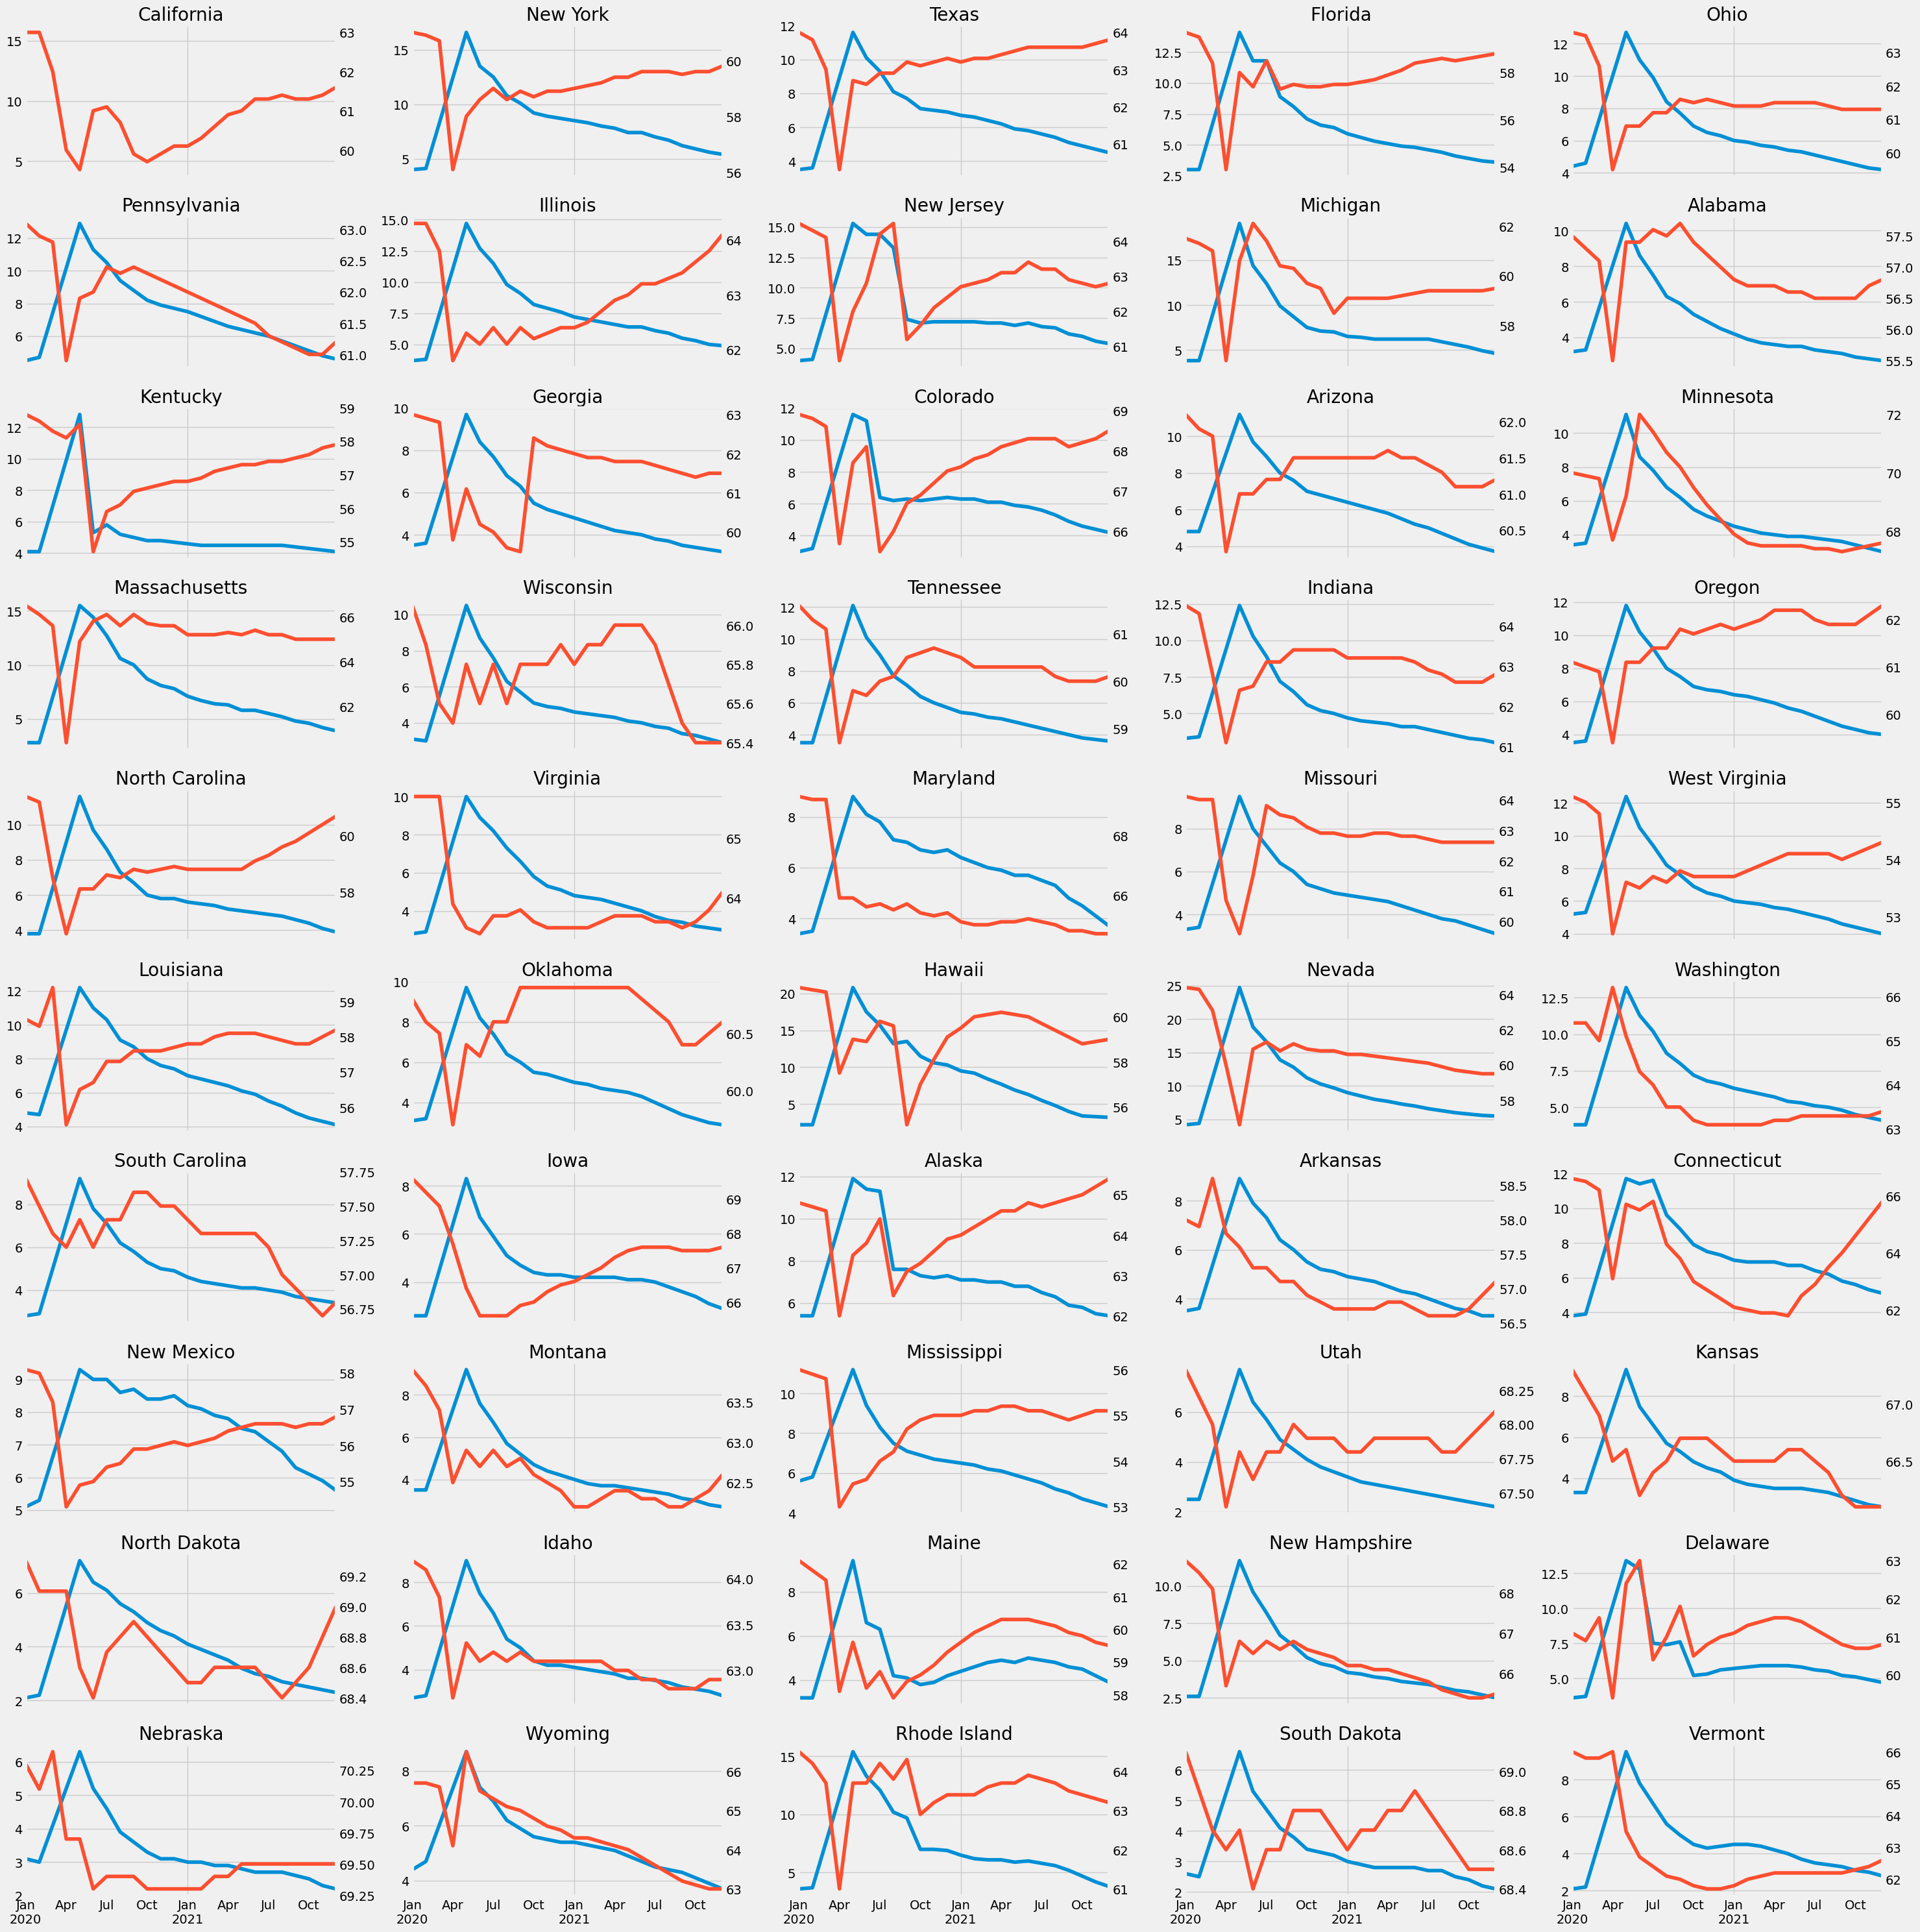

In [ ]:
fig, axs = plt.subplots(10, 5, figsize=(30, 30), sharex=True)
axs = axs.flatten()

i = 0
for state in uemp_states.columns:
    if state in ["District Of Columbia","Puerto Rico"]:
        continue
    ax2 = axs[i].twinx()
    uemp_states.query('index >= 2020 and index < 2022')[state] \
        .plot(ax=axs[i], label='Unemployment')
    part_states.query('index >= 2020 and index < 2022')[state] \
        .plot(ax=ax2, label='Participation', color=color_pal[1])
    ax2.grid(False)
    axs[i].set_title(state)
    i += 1
plt.tight_layout()
plt.show()

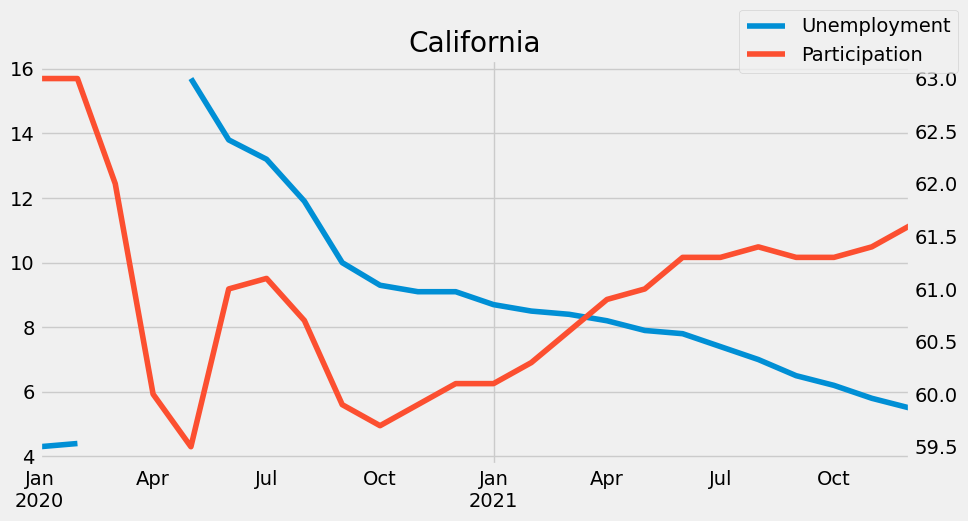

In [ ]:
state = 'California'
fig, ax = plt.subplots(figsize=(10, 5), sharex=True)
ax2 = ax.twinx()
uemp_states2 = uemp_states.asfreq('MS')
l1 = uemp_states2.query('index >= 2020 and index < 2022')[state] \
    .plot(ax=ax, label='Unemployment')
l2 = part_states.dropna().query('index >= 2020 and index < 2022')[state] \
    .plot(ax=ax2, label='Participation', color=color_pal[1])
ax2.grid(False)
ax.set_title(state)
fig.legend(labels=['Unemployment','Participation'])
plt.show()
